# Tuning Canny Edge Detection
This notebook contains some code to determine the best thresholds for canny edge detection (and also hashing afterwards) to decrease the false positive rate.

In [2]:
import cv2
import numpy as np
from PIL import Image
import imagehash
from matplotlib import pyplot as plt
from error_detection.utilities import *
from error_detection.image_diff import get_canny_edges


In [3]:
def load_data():
    """Load images as PIL Images and boolean labels where True indicates that one of the components (of one designator) has to be reworked"""
    comp_dict_PIL = {}
    for component_designator in ["C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "D1", "D2", "IC1", "J2", "L1", "R1", "R2", "R3", "R4", "R5", "R6", "R7", "R8", "R9", "U1", "U2", "U3", "U4"]:
        comp_list_PIL = []
        for board_id in ["B1", "B2", "B3"]:
            comp_list_PIL.append(Image.open("component_images/"+component_designator+"-"+board_id+".png"))
        comp_dict_PIL[component_designator] = comp_list_PIL
    return comp_dict_PIL
labels = [False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, False, True, False, False, False, False, False]
comp_dict_PIL = load_data()

C3
R3
R4
R5
R6
R8


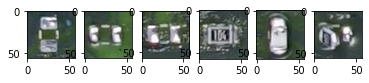

In [4]:
# show the defect components
designators = list(comp_dict_PIL.keys())
fig = plt.figure()
plot_id = 1
for i in range(len(designators)):
    if labels[i]:
        print(designators[i])
        fig.add_subplot(1, 6, plot_id)
        plt.imshow(img_to_cv2_img(comp_dict_PIL[designators[i]][0]))
        plot_id += 1
plt.show()

In [5]:
def evaluate(result):
    """Checks input against labels. Input has to be a list of booleans with the same length as the labels.
    Returns counts for True positives (tp), True negatives (tn), False positives (fp), False negatives (fn), i.e. the confusion matrix"""
    tp, tn, fp, fn = 0,0,0,0
    for i in range(len(result)):
        if labels[i] == result[i]:
            if labels[i]:
                tp += 1
            else:
                tn += 1
        else:
            if labels[i]:
                fn += 1
            else:
                fp += 1
    return (tp, tn, fn, fp)

In [6]:
def get_hashes(t_lower, t_upper):
    """Hashes the component images after applying canny edge detection with t_lower and t_upper thresholds.
    Computes the difference of hashes then. Returns a list which contains an array with the pairwise differences of hash values."""
    hash_list = []
    for designator in comp_dict_PIL:
        hashes = []
        for image in comp_dict_PIL[designator]:
            # Applying the Canny Edge filter
            hashes.append(imagehash.phash(img_to_pil_image(get_canny_edges(img_to_cv2_img(image), t_lower, t_upper))))
        hash_diffs = []
        for i in range(len(hashes)-1):
            for j in range(1, len(hashes)):
                if i != j:
                    hash_diffs.append(hashes[i] - hashes[j])
        hash_list.append(np.array(hash_diffs))
    return hash_list

In [7]:
def get_thresholds(hash_list):
    """Computes the highest threshold so that all defect components have at least one hash difference larger than the threshold.
    Also computes the largest hash difference of correct components. Given the threshold, the images are evaluated and the confusion matrix values are returned."""
    max_threshold = 64 # max value of the threshold s.t. all defects are detected initialised with max difference of hashes
    max_normal = 0 # max hash difference of correct components
    for i in range(len(hash_list)):
        if labels[i] and max_threshold > np.max(hash_list[i]):
            max_threshold = np.max(hash_list[i])
        if not labels[i] and max_normal < np.max(hash_list[i]):
            max_normal = np.max(hash_list[i])
            
    pred = []
    for i in range(len(hash_list)):
        if np.max(hash_list[i]) >= max_threshold:
            pred.append(True)
        else:
            pred.append(False)
    
    return evaluate(pred), max_threshold, max_normal

In [8]:
def param_search(min_spread=0):
    """Searches the best thresholds for canny edge detection (Takes time). The input is the minimal difference between the thresholds
    because filtering for values between e.g. 193 and 194 may not be meaningful"""
    complete_res = np.full((256, 256), 20) # contains FP rates for all thresholds (invalid thresholds have max FP rate)
    best_canny_thresh = []
    best_tn_rate = 0
    for low in range(0,255-min_spread):
        print(low, best_tn_rate)
        for high in range(min_spread+low+1,256):
            (tp, tn, fn, fp), min_outlier, max_normal = get_thresholds(get_hashes(low, high))
            complete_res[low, high] = fp
            if tp==6 and fn==0:
                if best_tn_rate < tn:
                    best_canny_thresh = [([low, high], min_outlier, max_normal)]
                    best_tn_rate = tn
                elif best_tn_rate == tn:
                    best_canny_thresh.append(([low, high], min_outlier, max_normal))
                    best_tn_rate = tn
    return best_canny_thresh, best_tn_rate, complete_res

In [ ]:
best_thresh, best_tn, res = param_search()

In [13]:
best_thresh # lower canny threshold, upper canny threshold, best hashing threshold, highest hash value for correct components

[([44, 196], 28, 36),
 ([44, 197], 28, 36),
 ([45, 196], 28, 36),
 ([45, 197], 28, 36)]

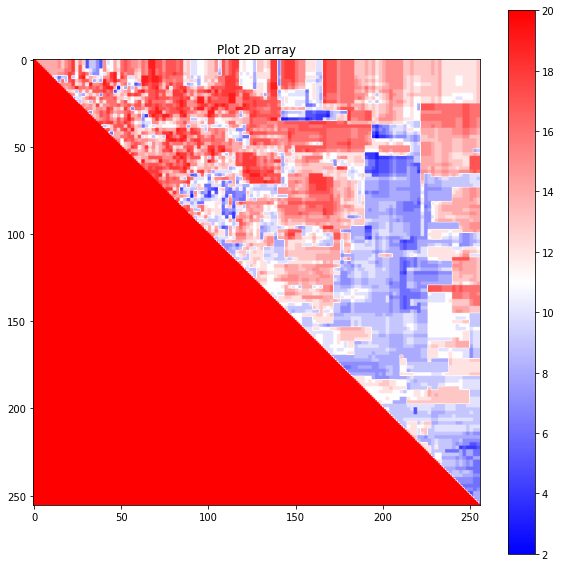

In [25]:
fig = plt.figure(figsize=(10,10))
plt.imshow(res,cmap="bwr")
plt.title("False positive rates for all thresholds")
plt.colorbar()
plt.show()

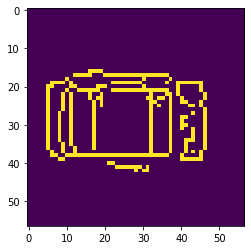

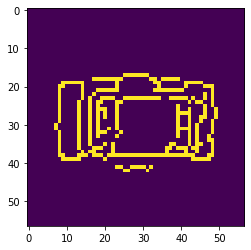

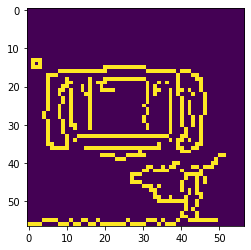

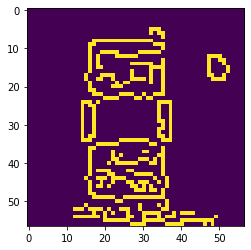

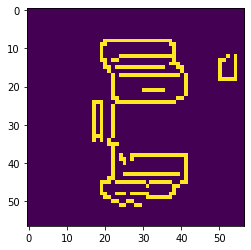

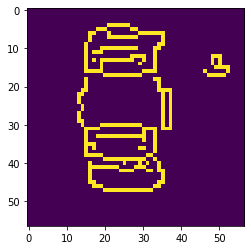

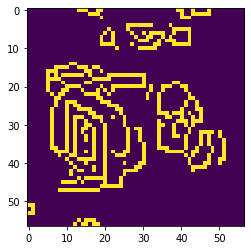

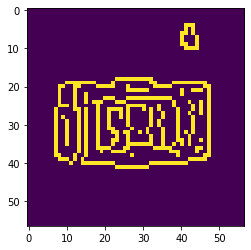

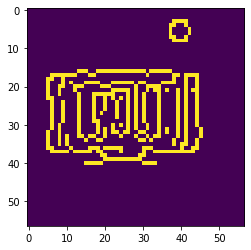

In [11]:
# plot some edge images
def plot_edges(low, high):
    for designator in ["C1", "C3", "R8"]:
        for image in comp_dict_PIL[designator]:
            # Applying the Canny Edge filter
            plt.imshow(cv2.Canny(img_to_cv2_img(image), low, high))
            plt.show()
plot_edges(44,197)